# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [4]:
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from libs.util import random_mask
from libs.pconv_model import PConvUnet

# Settings
MAX_BATCH_SIZE = 128

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
PConvUnet(512,512).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_57 (PConv2D)           [(None, 256, 256, 64 9472        input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 256, 256, 64) 0           p_conv2d_57[0][0]                
__________

# Testing out on single image

Shape of image is: 
(512, 512, 3)


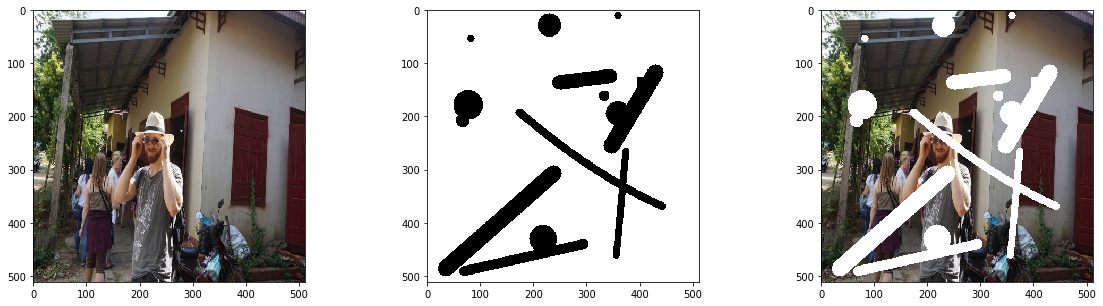

In [10]:
# Load image
img = cv2.imread('./data/sample_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512)) / 255
shape = img.shape
print("Shape of image is: ")
print(shape)

# Load mask
mask = random_mask(shape[0], shape[1])

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us. The generator is based off the ImageDataGenerator from keras.processing, which allows us to do all kinds of autmentation more easily. 

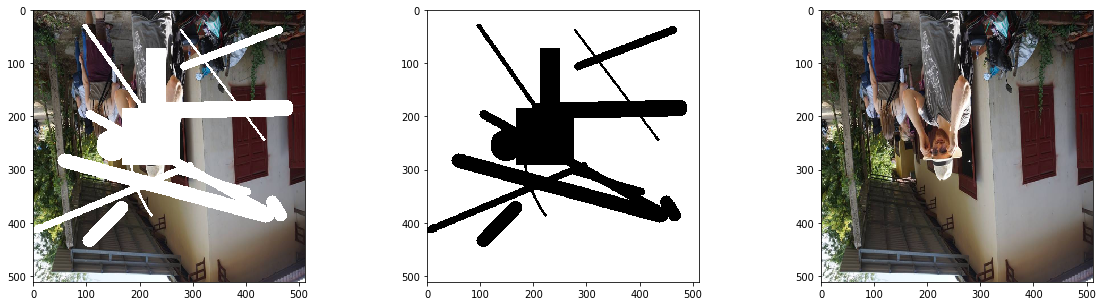

In [41]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
#     rotation_range=90,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip=True,
#     zoom_range = 0.5,
#     shear_range = 0.5,
    vertical_flip = True
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=4)

# Get samples & Display them
(masked, mask), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori[0,:,:,:])

## Training classifier on single image

In [12]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')                
        plt.show()

Epoch 1/1
10/10 [==============================] - 859s 86s/step - loss: 2298838.8625


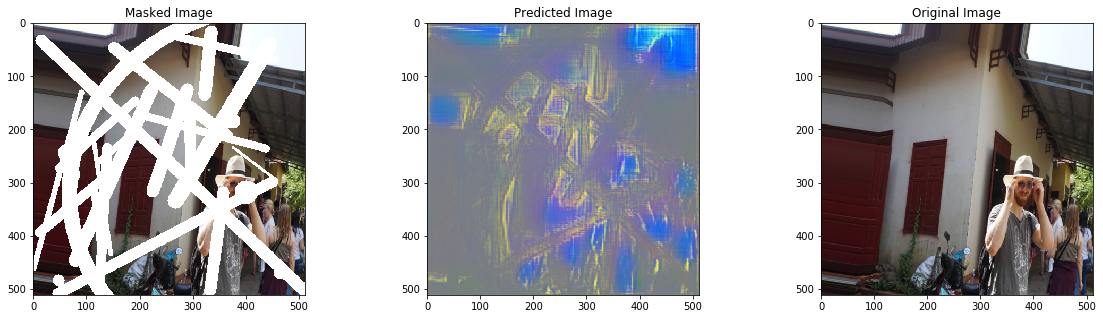

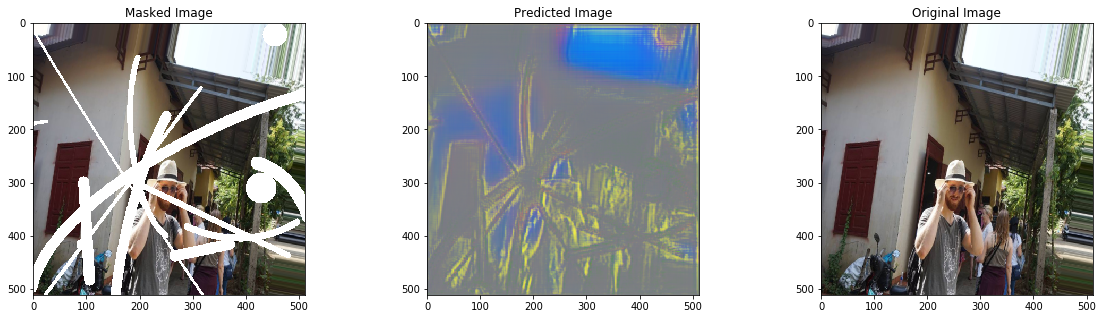

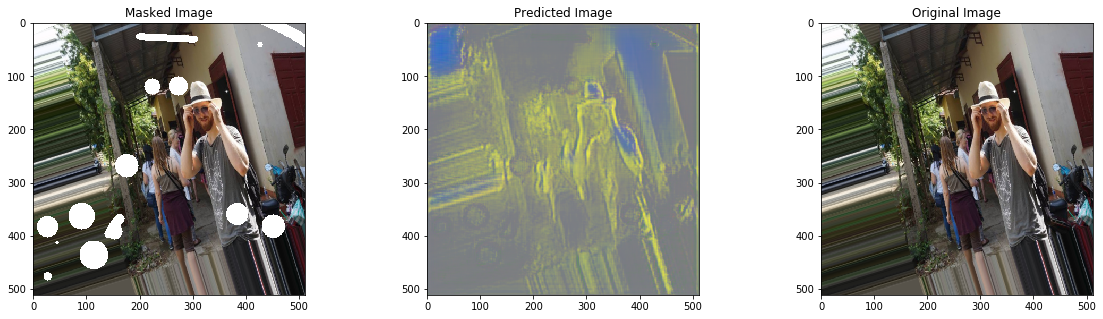

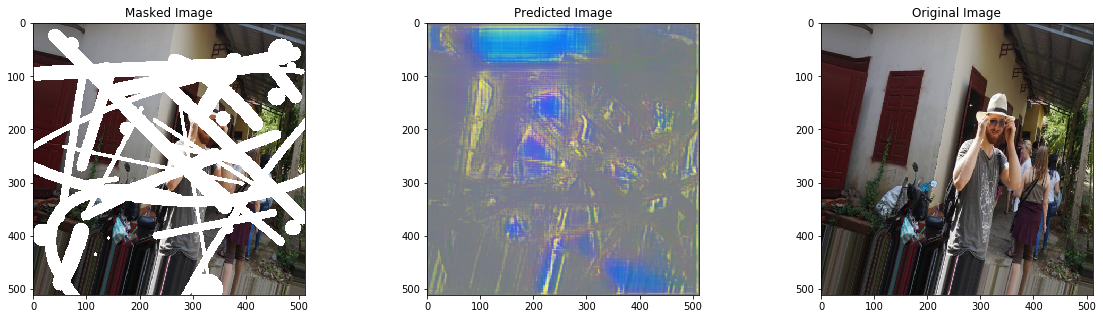

Epoch 2/2
10/10 [==============================] - 836s 84s/step - loss: 1905200.3375


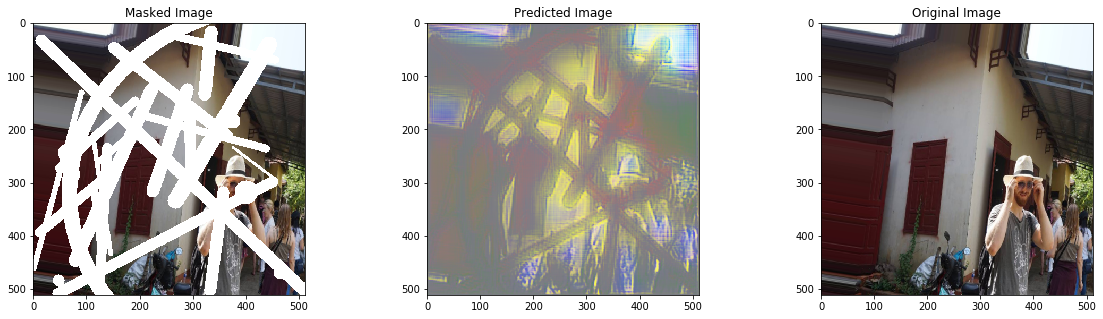

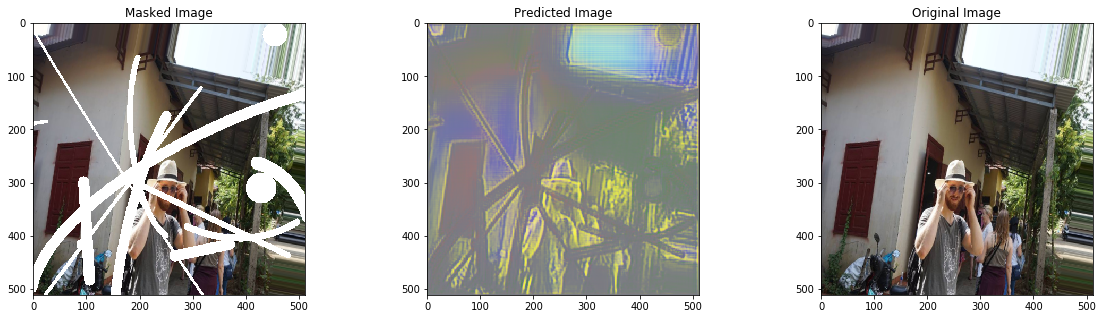

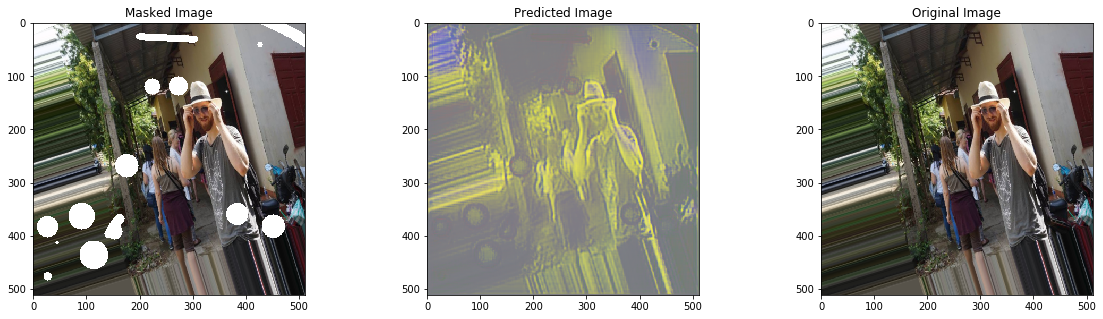

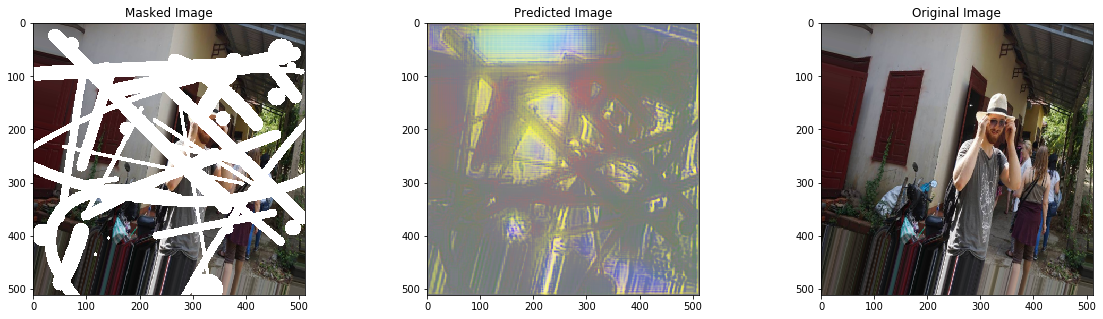

Epoch 3/3


In [ ]:
model = PConvUnet()
model.fit(
    generator, 
    steps_per_epoch=10,
    epochs=10,
    plot_callback=plot_callback,
)